# Fraud Detection Work

## Introduction and Motivation

The following code is intended for the final year project 'Machine Learning for Credit Card Fraud Detection' by Michael Brozhko.

### Import Libraries

In [16]:
#import relevant libaries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import datetime as dt
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

from sklearn.svm import SVC
from IPython import display
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer

### Combine CSVs of Dataset

Initially, the dataset uses was already pre split into training and testing data. However, for this experiment to be conducted with high validity, I recombined the dataset and randomly split later to ensure result reliability.

In [3]:
# The following code is intended to combine the two csv files associated with the dataset in use. 
# The dataset should be randomly split into testing and training data, as it is unclear how it was initially split

os.chdir("/Users/michael/Documents/Aston/FYP/Dataset")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

### Load Dataset

Load the dataset into a pandas dataframe and output the data types

In [2]:
# load dataset into a new dataframe and show head
df = pd.read_csv("/Users/michael/Documents/Aston/FYP/Dataset/combined_csv.csv")
df.head()

# List the initial datatypes of columns in dataframe
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

## Data Preprocessing

In the data preprocessing stage we deal with:
    -Type conversions
    -Removal of unnecessary data
    -Reformatting of data to more model-friendly format

### LabelEncoder() 

This function encodes strings as an integer label. Matching strings are encoded as the same integer value. This converts non numerical features to numeric.

In [3]:
from sklearn.preprocessing import LabelEncoder

#The following column deals with data preprocessing involving:
#   -Type conversions
#   -Removal of unnecessary data
#   -Reformatting of data to more model-friendly format

#drop unnecessary columns
dfn = df.drop(['Unnamed: 0','first','last','street','state','trans_num'],axis=1)

#create a LabelEncoder which matches strings to a integer label in order to convert non-numeric features to numerical format for the models
enc = LabelEncoder()

#convert following columns using LabelEncoder
dfn['gender'] = enc.fit_transform(dfn['gender'])
dfn['city'] = enc.fit_transform(dfn['city'])
dfn['job'] = enc.fit_transform(dfn['job'])

dfn = dfn.astype({"gender": int, "city": int, "job": int})

dfn.head()


,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,0,532,28654,36.0788,-81.1781,3495,372,1988-03-09,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,0,619,99160,48.8878,-118.2105,149,431,1978-06-21,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,1,474,83252,42.1808,-112.2620,4154,308,1962-01-19,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,1,84,59632,46.2306,-112.1138,1939,330,1967-01-12,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,1,217,24433,38.4207,-79.4629,99,116,1986-03-28,1325376186,38.674999,-78.632459,0


### Datetime Column Seperation

This segment deals with seperating the datetime column into seperate columns - year, hour, day, month. 
There may be a correlation between different times of day, different days and different months with fraudulent activity.

In [4]:
#The following functionality aims to seperate the datetime column
#so that it can be processed as multiple features
#   -This can offer greater performance
#   -Allow the identification of trends with regards to specific days, time of day, etc

#define several empty lists for following functionality
dfn['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
dfn['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
dfn['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
dfn['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month

dfn=dfn[['gender','job','city','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]

print(dfn.dtypes)
dfn.head()

gender          int64
job             int64
city            int64
amt           float64
zip             int64
lat           float64
long          float64
city_pop        int64
merch_lat     float64
merch_long    float64
age             int64
hour            int64
day             int64
month           int64
is_fraud        int64
dtype: object


,gender,job,city,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month,is_fraud
0,0,372,532,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,35,0,1,1,0
1,0,431,619,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,45,0,1,1,0
2,1,308,474,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,61,0,1,1,0
3,1,330,84,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,56,0,1,1,0
4,1,116,217,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,37,0,1,1,0


### Scaling Data

A standard scaler is used to standerdise the data with the normal distribution with mean = 0

In [28]:
def pca(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca3 = PCA(n_components=10,random_state=2020)
    X_pca = pca3.fit_transform(X_scaled)
    return X_pca

### K-Fold Cross Validation

In [29]:
def cross_validation(model, X, y):
    kf = KFold(n_splits=5)
    acc_score = []
 
    for train_index , test_index in kf.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)

        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/5

    print('accuracy of each fold - {}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))

## Results

The following functionality focuses on conducting the experiment and gaining results

### resultsReport()

In [30]:
def resultsReport(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    plotResults(accuracy, precision, recall, f1)
    

### plotResults()
The following function is defined to plot results based on a parameter 'report' which is a passed classification report

In [31]:
def plotResults(report):
    df = pd.DataFrame(report)
    df.iloc[:3, :2].T.plot(kind='bar')
    plt.show()

### runModels()

Avoids code repitiion by encapsulating all functionality in the function, allowing models on different data splits and sample sizes to be run by calling function and passing relevamt parameters

The function takes the features (x), labels (y) and text (t) as parameters. 

The function performs train test splitting so that all models are run on the same split (improves result reliability), model training and testing and a graphical output of performance metrics using plotResults()

In [32]:
# Function to run models

# Avoids code repitiion by encapsulating all functionality in the function, allowing models on different data splits 
# and sample sizes to be run by calling function and passing relevamt parameters


# The function takes the features (x), labels (y) and text (t) as parameters
# Performs:
#     1. Train-testing data split
#     2. Model training and testing
#     3. Output of performance metrics through classification_report

# The function does not return anything

def runModels(X, y, t):
    print("Performance metrics for "+t+" data")
    print(Counter(y))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    
#     KNN = KNeighborsClassifier(n_neighbors=3)
#     cross_validation(KNN, X, y)
#     Y_predK = KNN.fit(X_train, Y_train).predict(X_test)
#     KNNReport = classification_report(Y_test, Y_predK, digits=4,  output_dict=True)
#     KNNReport2 = classification_report(Y_test, Y_predK)
#     print(KNNReport2)
#     plotResults(KNNReport)
    
    regr = LogisticRegression(max_iter=1000, class_weight='balanced')
    #cross_validation(regr, X, y)
    Y_predL = regr.fit(X_train, Y_train).predict(X_test)
    regrReport = classification_report(Y_test, Y_predL, digits=4,  output_dict=True)
    regrReport2 = classification_report(Y_test, Y_predL)
    print(regrReport2)
    plotResults(regrReport)
    
#     guassian = GaussianNB()
#     cross_validation(guassian, X, y)
#     Y_predG = guassian.fit(X_train, Y_train).predict(X_test)
#     guassianReport = classification_report(Y_test, Y_predG, digits=4,  output_dict=True)
#     guassianReport2 = classification_report(Y_test, Y_predG)
#     print(guassianReport2)
#     plotResults(guassianReport)

    
#     Y_predRF = RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train).predict(X_test)
#     rfReport = classification_report(Y_test, Y_predRF, digits=4,  output_dict=True)
#     plotResults(rfReport)
    
#     Y_predMLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1).fit(X_train, Y_train).predict(X_test)
#     mlpReport = classification_report(Y_test, Y_predMLP, digits=4,  output_dict=True)
#     plotResults(mlpReport)

## Unsampled Data

Calculate prediction and analysis of results based on the unsampled data

0    3685486
1      19302
Name: is_fraud, dtype: int64
Performance metrics for Unsampled data data
Counter({0: 3685486, 1: 19302})
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1216168
           1       0.08      0.75      0.14      6413

    accuracy                           0.95   1222581
   macro avg       0.54      0.85      0.56   1222581
weighted avg       0.99      0.95      0.97   1222581



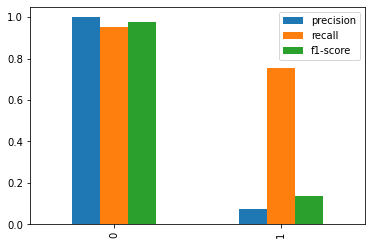

[[-4.29249198e-01 -3.18278012e-01 -2.48909110e-01 ... -3.01294937e-01
  -4.47020867e-02 -4.21667788e-02]
 [-4.93037520e-01 -3.24617961e-01  6.09711201e-01 ... -1.59613637e-01
   3.62770540e-01  1.55314391e-02]
 [ 5.27247566e-01 -3.24777694e-01  4.74287813e-01 ...  9.78904251e-03
   1.38603364e-01 -2.42374056e-03]
 ...
 [-5.20419852e-01 -2.00220823e-03  4.92482231e-01 ...  1.69326507e-02
   2.73218330e-01  1.14879840e-03]
 [ 5.22270045e-01 -4.51211685e-03  5.46780282e-01 ...  2.05880385e-01
   1.95841660e-01 -7.91981715e-03]
 [ 5.00079228e-01  6.03747485e-04  2.26995081e-01 ... -1.41916221e-01
  -6.74299073e-02 -1.55561324e-02]]
Performance metrics for PCA Transformed data
Counter({0: 3685486, 1: 19302})
              precision    recall  f1-score   support

           0       1.00      0.57      0.73   1216168
           1       0.01      0.56      0.01      6413

    accuracy                           0.57   1222581
   macro avg       0.50      0.57      0.37   1222581
weighted avg   

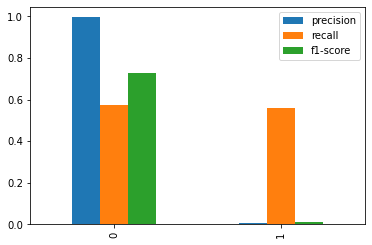

In [33]:
#split the data into features and labels

print(dfn['is_fraud'].value_counts())

#labels (y) are the what we are trying to predict and as such, is the 'is_fraud' column
y=dfn['is_fraud'].values
#format data and for features (X) remove 'is_fraud' column since this is what we are trying to predict
X=dfn.drop(['is_fraud'], axis='columns')
#Run Models
runModels(X, y, "Unsampled data")

X_pca = pca(X)
print(X_pca)
runModels(X_pca,y,'PCA Transformed')

In [11]:
# models_list =[LogisticRegression(random_state= 42),
#               GaussianNB(),
#               RandomForestClassifier(random_state = 42),
#               MLPClassifier(random_state=1, max_iter=300)]

# score_list = ["roc_auc", "accuracy", "f1", "precision", "recall"]

# t = plot_cv_score(X = X, y = y, models_list = models_list, cv = 5, scoring_list = score_list, refit = True)

## Random Oversampling

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, random oversampling will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Random Oversampling 1:1 data
Counter({0: 3685486, 1: 3685486})
              precision    recall  f1-score   support

           0       0.80      0.95      0.87   1215785
           1       0.94      0.76      0.84   1216636

    accuracy                           0.85   2432421
   macro avg       0.87      0.85      0.85   2432421
weighted avg       0.87      0.85      0.85   2432421



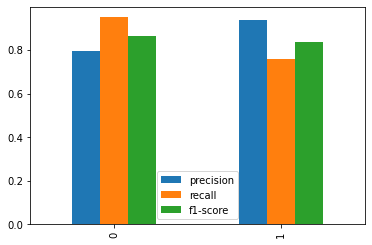

[[-0.50846125  0.59633128 -0.26772055 ... -0.18432705 -0.0509982
  -0.03946108]
 [-0.56268692  0.62723957 -0.31702515 ... -0.04619515  0.34301346
   0.01047171]
 [ 0.45494004  0.67136193 -0.30070872 ...  0.13284577  0.12708937
  -0.01363532]
 ...
 [ 0.51384265 -0.35362083 -0.06640095 ... -0.21668444  0.23109942
   0.01897939]
 [ 0.51230548  0.4480859   0.55287767 ...  0.40007348 -0.01715285
  -0.01779632]
 [-0.48364666 -0.48627811  0.2567252  ... -0.0033052   0.08741721
  -0.01012877]]
Performance metrics for PCA Transformed data
Counter({0: 3685486, 1: 19302})


ValueError: Found input variables with inconsistent numbers of samples: [7370972, 3704788]

In [34]:
# Perform random over-sampling on dataset

ros = RandomOverSampler(random_state=0)
X_over, y_over = ros.fit_resample(X, y)
runModels(X_over, y_over, "Random Oversampling 1:1")

X_pca = pca(X_over)
print(X_pca)
runModels(X_pca,y,'PCA Transformed')

# ros2 = RandomOverSampler(random_state=0, sampling_strategy={1:368549})
# X_over2, y_over2 = ros2.fit_resample(X, y)
# runModels(X_over2, y_over2, "Random Oversampling 10:1")

# ros3 = RandomOverSampler(random_state=0, sampling_strategy={1:36855})
# X_over3, y_over3 = ros3.fit_resample(X, y)
# runModels(X_over3, y_over3, "Random Oversampling 100:1")

## SMOTE - Systematic Minority Oversampling

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, smote will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Systematic Majority Oversampling 1:1 data
Counter({0: 3685486, 1: 3685486})
              precision    recall  f1-score   support

           0       0.80      0.95      0.87   1215785
           1       0.94      0.76      0.84   1216636

    accuracy                           0.85   2432421
   macro avg       0.87      0.85      0.85   2432421
weighted avg       0.87      0.85      0.85   2432421



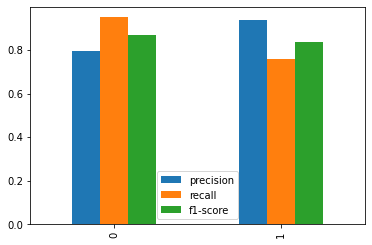

Performance metrics for Systematic Majority Oversampling 10:1 data
Counter({0: 3685486, 1: 368549})
              precision    recall  f1-score   support

           0       0.97      0.95      0.96   1216355
           1       0.60      0.76      0.67    121477

    accuracy                           0.93   1337832
   macro avg       0.79      0.85      0.81   1337832
weighted avg       0.94      0.93      0.94   1337832



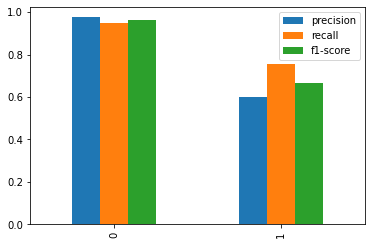

Performance metrics for Systematic Majority Oversampling 100:1 data
Counter({0: 3685486, 1: 36855})
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1216128
           1       0.14      0.76      0.23     12245

    accuracy                           0.95   1228373
   macro avg       0.57      0.85      0.60   1228373
weighted avg       0.99      0.95      0.97   1228373



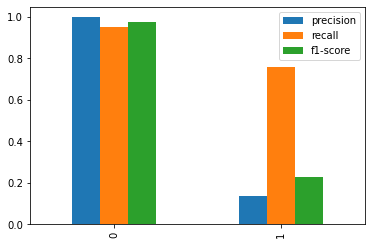

In [39]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
runModels(X_smote, y_smote, "Systematic Majority Oversampling 1:1")

smote2 = SMOTE(random_state=42, sampling_strategy={1:368549})
X_smote2, y_smote2 = smote2.fit_resample(X, y)
runModels(X_smote2, y_smote2, "Systematic Majority Oversampling 10:1")

smote3 = SMOTE(random_state=42, sampling_strategy={1:36855})
X_smote3, y_smote3  = smote3.fit_resample(X, y)
runModels(X_smote3, y_smote3, "Systematic Majority Oversampling 100:1")

## Random Undersampling

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset.

For this experiment, we will undersample the data in ratios 1:1, 10:1 and 100:1 Since the data was at ratio 368546:19302 majority class to minority class, random undersampling will scale down the number of datapoints for the majority class to match the above ratios.

Performance metrics for Random Undersampling 1:1 data
Counter({0: 19302, 1: 19302})
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      6388
           1       0.94      0.76      0.84      6352

    accuracy                           0.86     12740
   macro avg       0.87      0.86      0.86     12740
weighted avg       0.87      0.86      0.86     12740



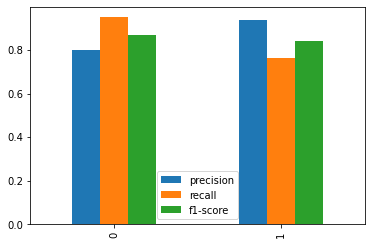

Performance metrics for Random Undersampling 10:1 data
Counter({0: 193020, 1: 19302})
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     63766
           1       0.60      0.75      0.67      6301

    accuracy                           0.93     70067
   macro avg       0.79      0.85      0.81     70067
weighted avg       0.94      0.93      0.94     70067



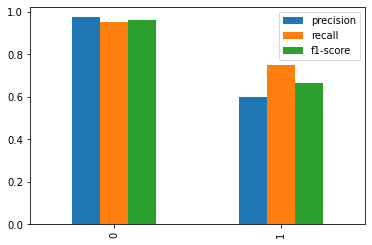

Performance metrics for Random Undersampling 100:1 data
Counter({0: 1930200, 1: 19302})
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    636862
           1       0.14      0.76      0.24      6474

    accuracy                           0.95    643336
   macro avg       0.57      0.86      0.61    643336
weighted avg       0.99      0.95      0.97    643336



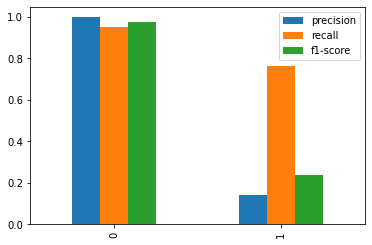

In [38]:
# Perform random under-sampling on dataset

rus = RandomUnderSampler(random_state=0)
X_under, y_under = rus.fit_resample(X, y)
runModels(X_under, y_under, "Random Undersampling 1:1")

rus2 = RandomUnderSampler(random_state=0, sampling_strategy={0:193020, 1:19302})
X_under2, y_under2 = rus2.fit_resample(X, y)
runModels(X_under2, y_under2, "Random Undersampling 10:1")

rus3 = RandomUnderSampler(random_state=0, sampling_strategy={0:1930200, 1:19302})
X_under3, y_under3 = rus3.fit_resample(X, y)
runModels(X_under3, y_under3, "Random Undersampling 100:1")

## Nearmiss Undersampling

NearMiss (V3) involves selecting a given number of majority class examples for each example in the minority class that are closest and deleting them from the dataset.

For this experiment, we will undersample the data in ratios 1:1, 10:1 and 100:1 Since the data was at ratio 368546:19302 majority class to minority class, near-miss undersampling will scale down the number of datapoints for the majority class to match the above ratios.

/Users/michael/opt/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Performance metrics for Near Miss Undersampling 1:1 data
Counter({1: 19302, 0: 18210})
              precision    recall  f1-score   support

           0       0.54      0.64      0.58      6018
           1       0.58      0.48      0.53      6361

    accuracy                           0.56     12379
   macro avg       0.56      0.56      0.56     12379
weighted avg       0.56      0.56      0.55     12379



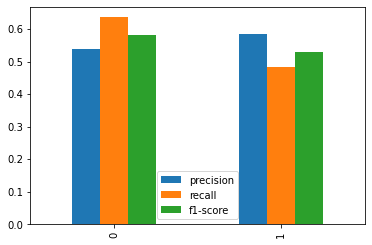

/Users/michael/opt/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Performance metrics for Near Miss Undersampling 10:1 data
Counter({1: 19302, 0: 18210})
              precision    recall  f1-score   support

           0       0.54      0.64      0.58      6018
           1       0.58      0.48      0.53      6361

    accuracy                           0.56     12379
   macro avg       0.56      0.56      0.56     12379
weighted avg       0.56      0.56      0.55     12379



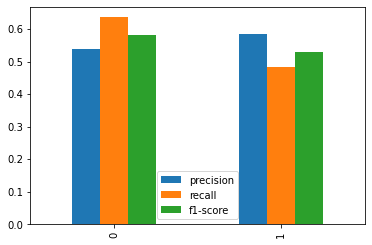

/Users/michael/opt/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Performance metrics for Near Miss Undersampling 100:1 data
Counter({1: 19302, 0: 18210})
              precision    recall  f1-score   support

           0       0.54      0.64      0.58      6018
           1       0.58      0.48      0.53      6361

    accuracy                           0.56     12379
   macro avg       0.56      0.56      0.56     12379
weighted avg       0.56      0.56      0.55     12379



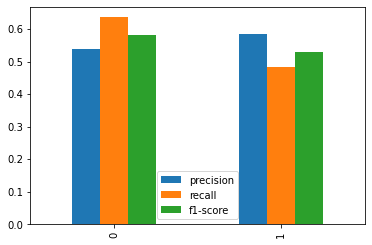

In [36]:
nearmiss = NearMiss(version=3)
X_nearmiss, y_nearmiss= nearmiss.fit_resample(X, y)
runModels(X_nearmiss, y_nearmiss, "Near Miss Undersampling 1:1")

nearmiss2 = NearMiss(version=3, sampling_strategy={0:193020})
X_nearmiss2, y_nearmiss2= nearmiss2.fit_resample(X, y)
runModels(X_nearmiss, y_nearmiss, "Near Miss Undersampling 10:1")

nearmiss3 = NearMiss(version=3, sampling_strategy={0:1930200})
X_nearmiss3, y_nearmiss3= nearmiss3.fit_resample(X, y)
runModels(X_nearmiss3, y_nearmiss3, "Near Miss Undersampling 100:1")